In [ ]:
import kagglehub
import os
import re
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from textblob import TextBlob
import nltk

# **DATA COLLECTION**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/cyberbullying-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/cyberbullying-classification/versions/1


In [ ]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/andrewmvd/cyberbullying-classification/versions/1/cyberbullying_tweets.csv


In [ ]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/andrewmvd/cyberbullying-classification/versions/1/cyberbullying_tweets.csv')

# **DATA EXPLORATION**

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.shape

(47692, 2)

In [ ]:
count = df.shape[0]
print(f"Total count of the dataset: {count}")

Total count of the dataset: 47692


In [ ]:
unique_categories = df['cyberbullying_type'].nunique()
print(f"Number of unique categories: {unique_categories}")

Number of unique categories: 6


In [ ]:
category_counts = df['cyberbullying_type'].value_counts()
print(category_counts)

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


# **DATA PREPROCESSING**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df['binary_label'] = df['cyberbullying_type'].apply(lambda x: 1 if x != 'not_cyberbullying' else 0)

In [ ]:
category_counts = df['cyberbullying_type'].value_counts()
print(category_counts)

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


In [ ]:
df.head()

,tweet_text,cyberbullying_type,binary_label
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0


In [ ]:
df = df.drop(columns=['cyberbullying_type'])
df = df.rename(columns={'tweet_text': 'tweet', 'binary_label': 'label'})
df.head()

,tweet,label
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


In [ ]:
df.duplicated().sum()

166

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
tweet,0
label,0


<ipython-input-20-69fc41c80f1b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


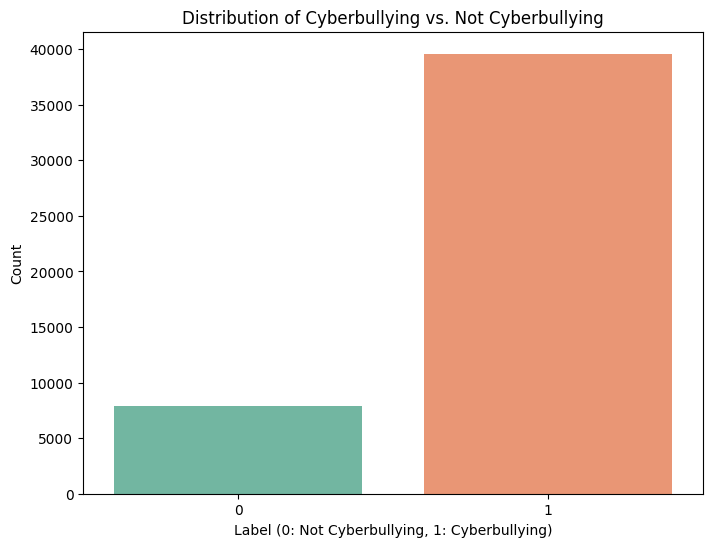

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of labels (binary_label or label)
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Distribution of Cyberbullying vs. Not Cyberbullying')
plt.xlabel('Label (0: Not Cyberbullying, 1: Cyberbullying)')
plt.ylabel('Count')
plt.show()


# **FEATURE ENGINEERING**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure the necessary NLTK datasets are available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Function for text cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions (@)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (#)
    text = re.sub(r'#\w+', '', text)
    # Remove non-alphanumeric characters (except spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

In [ ]:
# Function for tokenization and stopword removal
def preprocess_tweet(text):
    # Clean the text
    text = clean_text(text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
# Apply preprocessing to each tweet in the 'tweet' column
df['processed_tweet'] = df['tweet'].apply(preprocess_tweet)

In [ ]:
df.drop(columns=['tweet'], inplace=True)

In [ ]:
category_counts = df['label'].value_counts()
print(category_counts)

label
1    39589
0     7937
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['label'] == 1]
df_minority = df[df['label'] == 0]

# Oversample the minority class
df_minority_oversampled = resample(df_minority,
                                   replace=True,     # Sample with replacement
                                   n_samples=len(df_majority),  # Match the number of majority class samples
                                   random_state=42)  # For reproducibility

# Combine the majority class with the oversampled minority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Verify the class distribution
category_counts_balanced = df_balanced['label'].value_counts()
print(category_counts_balanced)

label
1    39589
0    39589
Name: count, dtype: int64


# **DATA VISUALIZATION**

<ipython-input-28-a16b4f020558>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_balanced, x='label', palette='Set2')


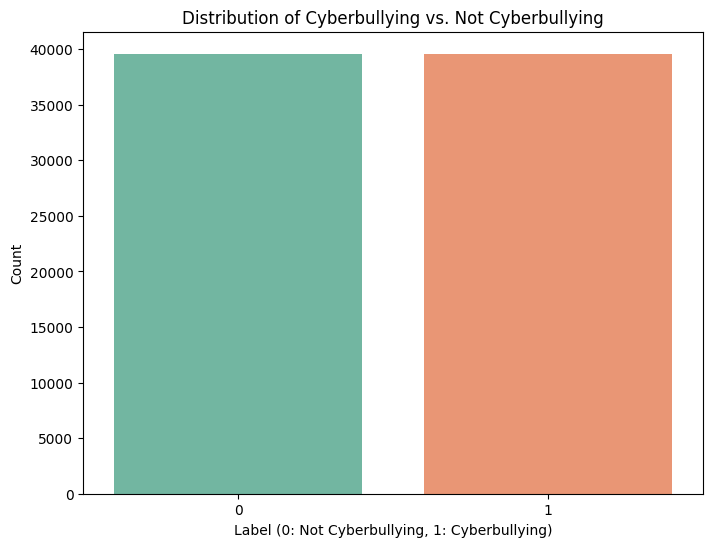

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of labels (binary_label or label)
plt.figure(figsize=(8, 6))
sns.countplot(data=df_balanced, x='label', palette='Set2')
plt.title('Distribution of Cyberbullying vs. Not Cyberbullying')
plt.xlabel('Label (0: Not Cyberbullying, 1: Cyberbullying)')
plt.ylabel('Count')
plt.show()

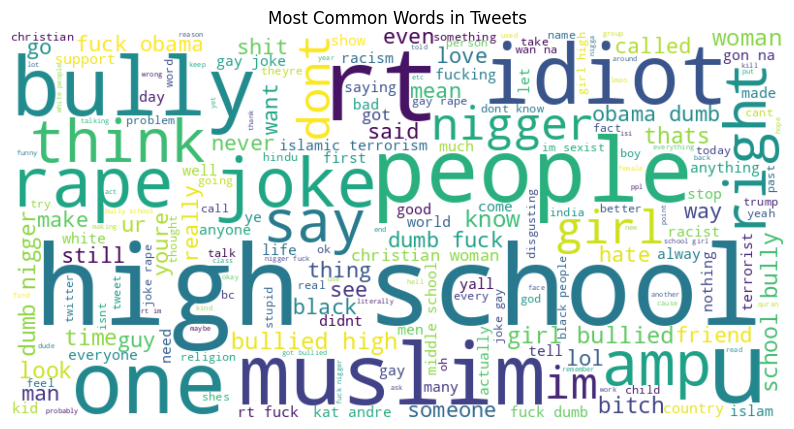

In [ ]:
from wordcloud import WordCloud

# Combine all tweets into a single text
all_tweets = " ".join(df_balanced['processed_tweet'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Tweets')
plt.show()

# **MODEL TRAINING AND EVALUATION**

In [ ]:
from sklearn.model_selection import train_test_split

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2000)

# Fit and transform the processed tweets into TF-IDF features
X_tfidf = vectorizer.fit_transform(df_balanced['processed_tweet'])

# Convert the TF-IDF result to a dense array for easier inspection
X_tfidf_dense = X_tfidf.toarray()

# Separate features (X) and labels (y) from the balanced dataframe
X = X_tfidf_dense
y = df_balanced['label']

# Perform the train-test split (80% training, 20% testing by default)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-31-81c7cba5fb47>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_df['tfidf_sum'][:top_n], y=tfidf_df['word'][:top_n], palette='Blues_d')


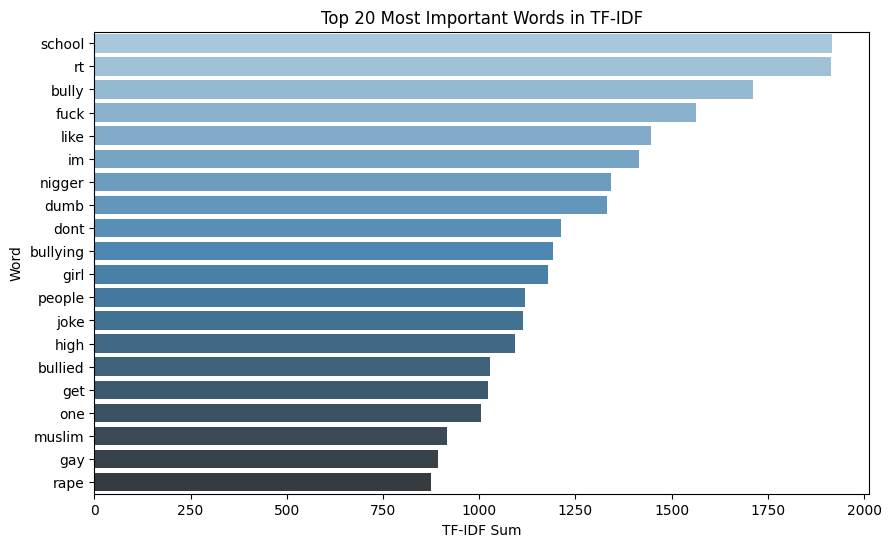

In [ ]:
import numpy as np

# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the sum of the TF-IDF values for each feature (word)
tfidf_sum = X_tfidf.sum(axis=0).A1

# Create a DataFrame with feature names and their corresponding sum of TF-IDF values
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_sum': tfidf_sum})

# Sort the words by their sum of TF-IDF values
tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

# Plot the top N words with the highest TF-IDF values
top_n = 20  # Adjust as needed
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_df['tfidf_sum'][:top_n], y=tfidf_df['word'][:top_n], palette='Blues_d')
plt.title(f'Top {top_n} Most Important Words in TF-IDF')
plt.xlabel('TF-IDF Sum')
plt.ylabel('Word')
plt.show()

### NAIVE BAYES

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = nb_model.predict(X_test)
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}')
report_nb = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

Test Set Accuracy: 0.7868
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      7971
           1       0.76      0.83      0.80      7865

    accuracy                           0.79     15836
   macro avg       0.79      0.79      0.79     15836
weighted avg       0.79      0.79      0.79     15836



## LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the classifier
clf = LogisticRegression()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
report_lr = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

Accuracy: 0.8489
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      7971
           1       0.89      0.79      0.84      7865

    accuracy                           0.85     15836
   macro avg       0.85      0.85      0.85     15836
weighted avg       0.85      0.85      0.85     15836



## LOGISTIC REGRESSION WITH FINE TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L2 is supported for dense data
    'solver': ['lbfgs']  # Solver for Logistic Regression
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score from grid search
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Test set evaluation
print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}')
report_lr_tune = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.8474787728140983
Test Set Accuracy: 0.8522
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      7971
           1       0.89      0.80      0.84      7865

    accuracy                           0.85     15836
   macro avg       0.86      0.85      0.85     15836
weighted avg       0.86      0.85      0.85     15836



## KNN WITH DIMENSIONALITY REDUCTION

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the KNN model
from sklearn.decomposition import PCA

pca = PCA(n_components=50)  # Reduce to 50 dimensions
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', n_jobs=-1)

knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

print(f'Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}')
report_knn = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

Test Set Accuracy: 0.8563
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      7971
           1       0.95      0.75      0.84      7865

    accuracy                           0.86     15836
   macro avg       0.87      0.86      0.85     15836
weighted avg       0.87      0.86      0.85     15836



## **DATA ANALYSIS**

<Figure size 1200x600 with 0 Axes>

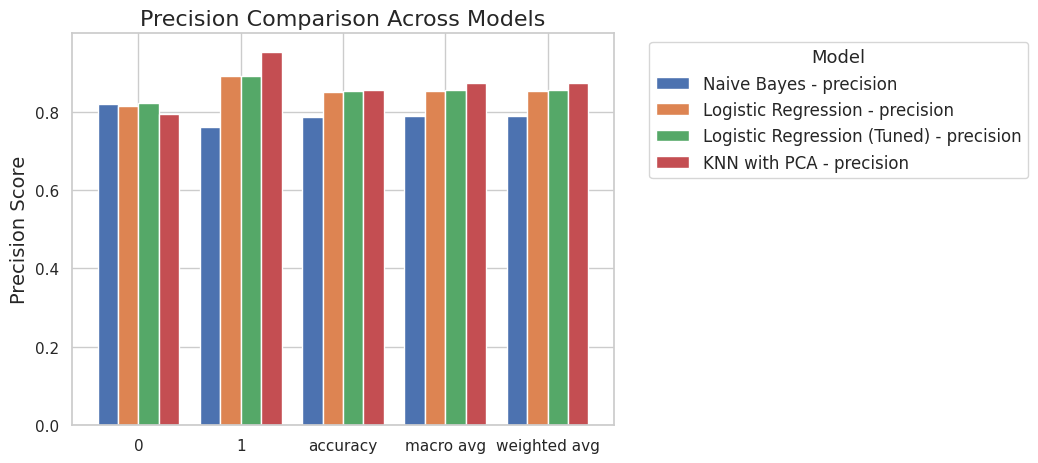

<Figure size 1200x600 with 0 Axes>

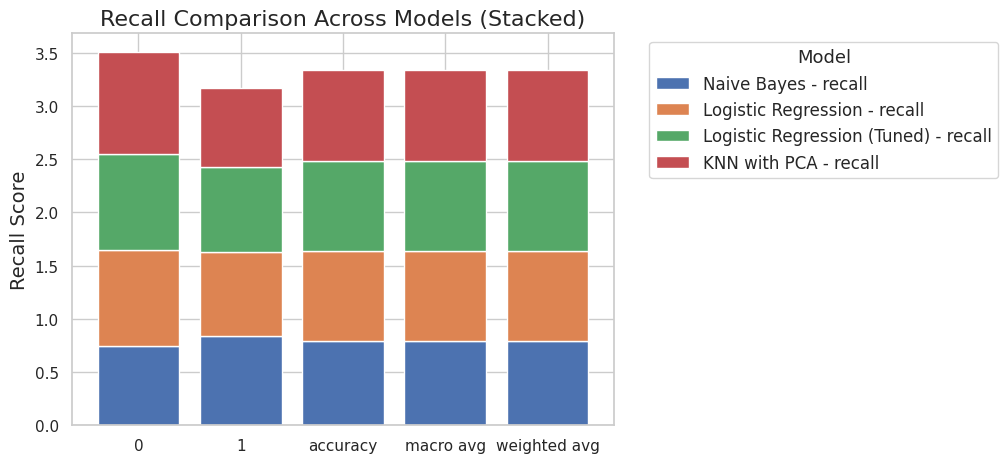

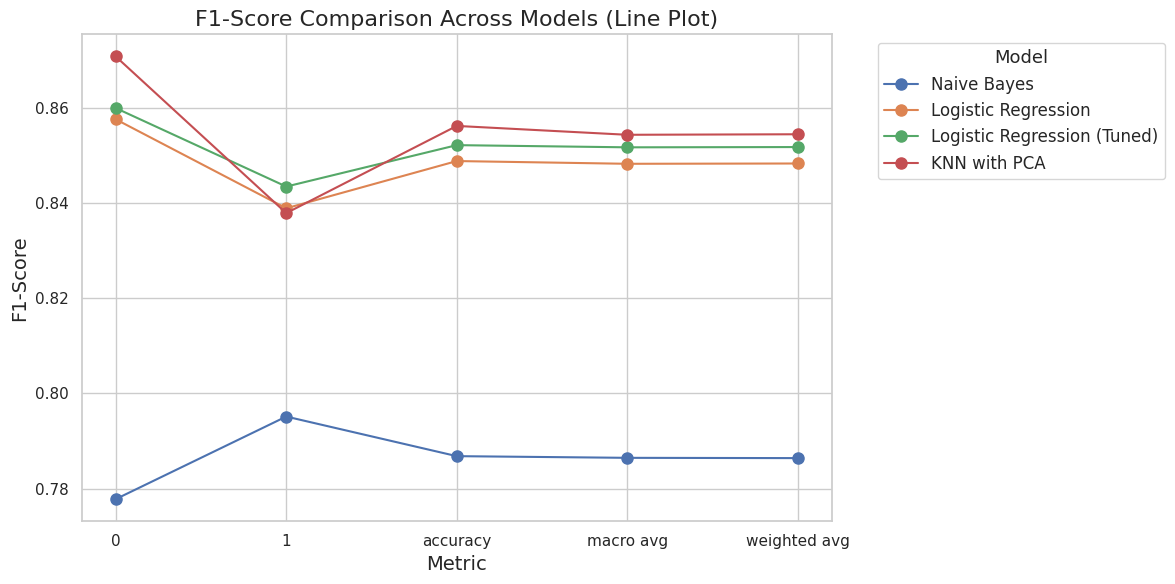

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

reports = {}
reports['KNN with PCA'] = pd.DataFrame(report_knn).transpose()[['precision', 'recall', 'f1-score']]
reports['Logistic Regression (Tuned)'] = pd.DataFrame(report_lr_tune).transpose()[['precision', 'recall', 'f1-score']]
reports['Logistic Regression'] = pd.DataFrame(report_lr).transpose()[['precision', 'recall', 'f1-score']]
reports['Naive Bayes'] = pd.DataFrame(report_nb).transpose()[['precision', 'recall', 'f1-score']]


reports = {
     'Naive Bayes': report_nb,
     'Logistic Regression': report_lr,
     'Logistic Regression (Tuned)': report_lr_tune,
     'KNN with PCA': report_knn
}

# Convert each classification report to a DataFrame
reports_df = {}
for model_name, report in reports.items():
    report_df = pd.DataFrame(report).transpose()  # Transpose to get metrics as rows
    reports_df[model_name] = report_df[['precision', 'recall', 'f1-score']]  # Select only relevant columns

# Now, concatenate the DataFrames for each model into one large DataFrame
final_report_df = pd.concat(reports_df, axis=1)

# Flatten the MultiIndex columns (Model name + metric)
final_report_df.columns = [f"{model} - {metric}" for model, metric in final_report_df.columns]

# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Darker color palette for plots
colors = sns.color_palette("deep", n_colors=4)

# Plotting for Precision (Grouped Bar Plot)
plt.figure(figsize=(12, 6))
final_report_df[['Naive Bayes - precision', 'Logistic Regression - precision',
                  'Logistic Regression (Tuned) - precision', 'KNN with PCA - precision']].plot(
    kind='bar', color=colors, width=0.8)
plt.title('Precision Comparison Across Models', fontsize=16)
plt.ylabel('Precision Score', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title='Model', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.show()

# Plotting for Recall (Stacked Bar Plot)
plt.figure(figsize=(12, 6))
final_report_df[['Naive Bayes - recall', 'Logistic Regression - recall',
                  'Logistic Regression (Tuned) - recall', 'KNN with PCA - recall']].plot(
    kind='bar', stacked=True, color=colors, width=0.8)
plt.title('Recall Comparison Across Models (Stacked)', fontsize=16)
plt.ylabel('Recall Score', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title='Model', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.show()

# Plotting for F1-Score (Line Plot)
plt.figure(figsize=(12, 6))
for model in reports_df.keys():
    plt.plot(final_report_df.index, final_report_df[f'{model} - f1-score'], label=model, marker='o', linestyle='-', markersize=8)

plt.title('F1-Score Comparison Across Models (Line Plot)', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Model', title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.tight_layout()
plt.show()


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Assuming df_balanced is your balanced DataFrame with 'processed_tweet' and 'label' columns
texts = df_balanced['processed_tweet'].tolist()
labels = df_balanced['label'].tolist()

# Tokenize the texts
encoded_texts = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Split the data
input_ids = encoded_texts['input_ids']
attention_mask = encoded_texts['attention_mask']
labels = torch.tensor(labels)

train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)

# Create DataLoaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

# Set up the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Evaluation
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(batch[2].cpu().numpy())

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(classification_report(val_true, val_preds))

# Final evaluation
print("Final Evaluation:")
print(classification_report(val_true, val_preds))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

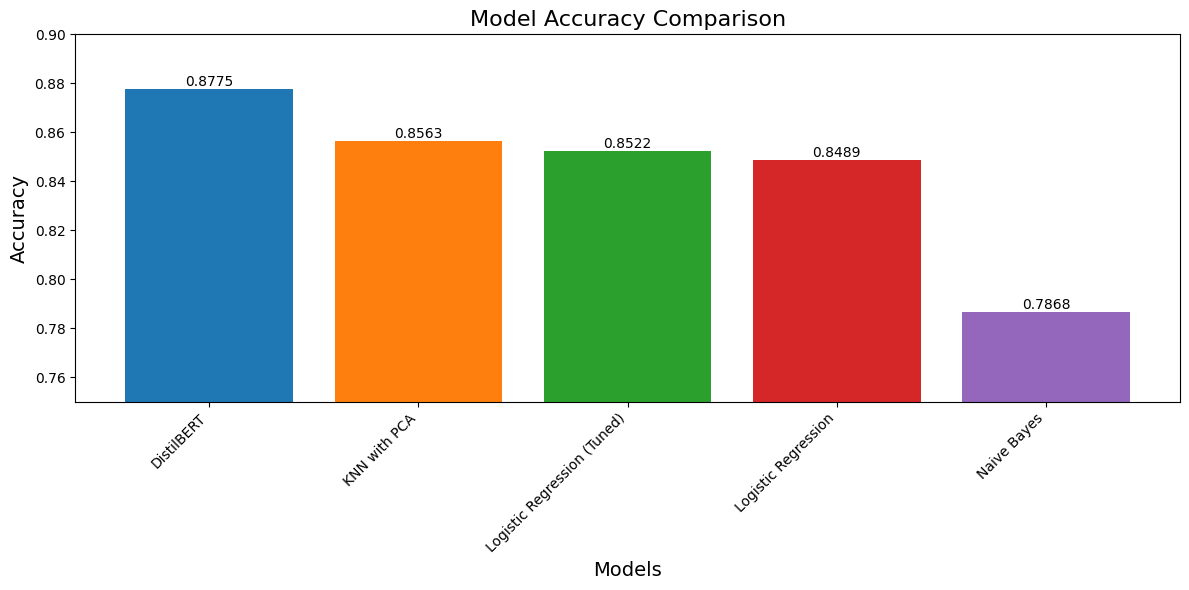

In [ ]:
import matplotlib.pyplot as plt

models = ['DistilBERT', 'KNN with PCA', 'Logistic Regression (Tuned)', 'Logistic Regression', 'Naive Bayes']
accuracies = [0.8775, 0.8563, 0.8522, 0.8489, 0.7868]

plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.75, 0.90)  # Set y-axis limits for better visualization

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()